NGÀY 1:

CHỦ ĐỀ: XỬ LÝ DỮ LIỆU ĐẦU VÀO LÀ CẢM BIẾN NHIỆT ĐỘ (Temperature Sensor).

TƯ DUY TỔNG QUÁT: Tôi đang đo cái gì? Đo để làm gì? và quyết định được gì khi dựa trên số liệu đó?.

Mục tiêu: 

    - Hiểu dữ liệu cảm biến là gì?.

    - Biết python xử lý dữ liệu sensor như thế nào?.

    - Dùng được: Biến, hàm, list, vòng lặp.

    - Vẽ được biểu đồ nhiệt độ theo thời gian, có lập ngưỡng overhead.

 Định nghĩa bài toán:

 Một motor trong nhà máy SMT có sensor nhiệt độ như sau:

    - Đo mỗi 10 giây, lấy tổng cộng 100 mẫu dữ liệu.

    - Nhiệt độ bình thường được xác định trong khoảng: 40-70 độ C.

    - Thiết lập ngưỡng cảnh báo quá nhiệt là 65 độ.

 Nhiệm vụ:

    - Cell 0: Import thư viện liên quan.

    - Cell 1: Tạo dữ liệu nhiệt độ, data type, làm tròn số.

    - Cell 2: Tạo timestamp(Tần suất lấy mẫu).

    - Cell 3: Lưu và in thông tin dữ liệu.

    - Cell 5: Phân tích dữ liệu cảm biến.

    - Cell 6: Biểu diễn biểu đồ.


In [73]:
import random
import numpy as np
from decimal import *
from datetime import *
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [74]:
temperature_data = []

for sample in range(100):
    temp = Decimal(str(random.uniform(40,70))).quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
    temperature_data.append(temp)  #sensor gửi dữ liệu
temperature_data[:3]

[Decimal('60.19'), Decimal('46.15'), Decimal('55.25')]

In [75]:
# Create timestamped data
timestamped_data = []
start_time = datetime.now() # Thời điểm bắt đầu đo
interval = timedelta(seconds=10)  # 10 giây lấy mẫu một lần

for i, temp in enumerate(temperature_data):
    record = {
        'timestamp': start_time + i * interval,
        'temperature': temp
    }
    timestamped_data.append(record)

timestamped_data[:1]

[{'timestamp': datetime.datetime(2026, 1, 7, 10, 35, 1, 21780),
  'temperature': Decimal('60.19')}]

In [76]:
# Helper function for decimal formatting
def format_decimal(value):
    return value.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)

# Display basic statistics
max_temp = max(temperature_data)
min_temp = min(temperature_data)
avg_temp = sum(temperature_data) / len(temperature_data)

print(f"Max Temp: {format_decimal(max_temp)} °C")
print(f"Min Temp: {format_decimal(min_temp)} °C")
print(f"Average Temp: {format_decimal(avg_temp)} °C")

Max Temp: 69.31 °C
Min Temp: 40.33 °C
Average Temp: 56.19 °C


In [77]:
# Store statistics in dict for reference
temp_stats = {
    "max": format_decimal(max(temperature_data)),
    "min": format_decimal(min(temperature_data)),
    "avg": format_decimal(sum(temperature_data) / len(temperature_data))
}
temp_stats

{'max': Decimal('69.31'), 'min': Decimal('40.33'), 'avg': Decimal('56.19')}

In [78]:
# Extract data for visualization and analysis
times = [d["timestamp"] for d in timestamped_data]
temps = [float(d["temperature"]) for d in timestamped_data]

# Define overheat threshold
OVERHEAT_THRESHOLD = Decimal('65.00')
THRESHOLD_FLOAT = float(OVERHEAT_THRESHOLD)  # Pre-convert for efficiency

In [79]:
OVERHEAT_THRESHOLD = Decimal('65.00')

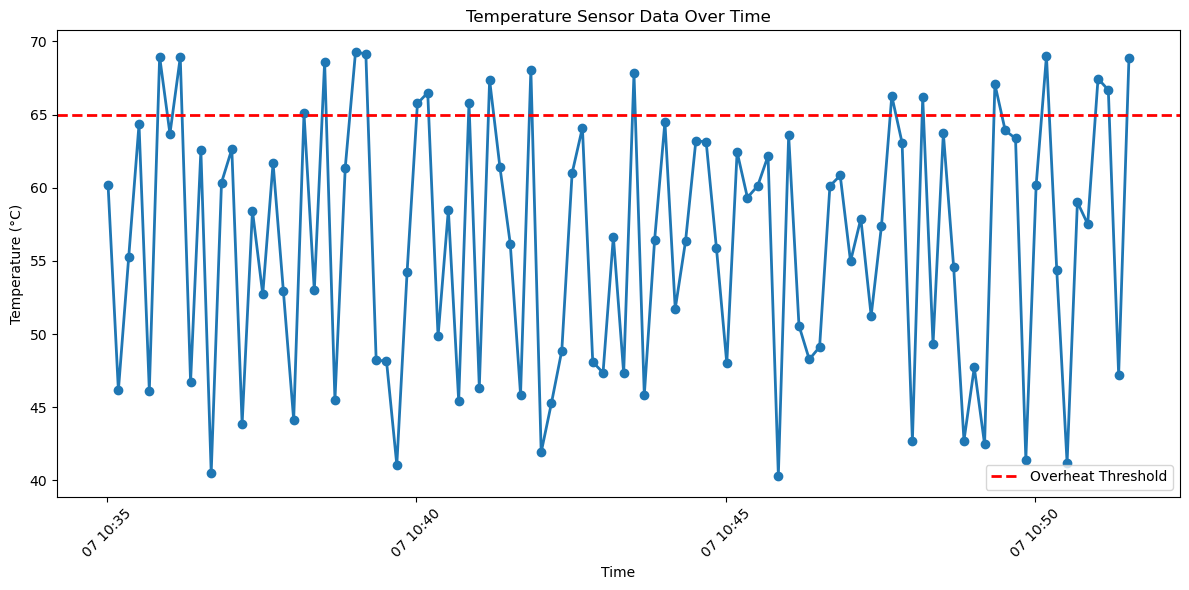

In [80]:
# Visualize temperature data with threshold
plt.figure(figsize=(12, 6))
plt.plot(times, temps, marker='o', linewidth=2)
plt.axhline(y=THRESHOLD_FLOAT, color='r', linestyle='--', label='Overheat Threshold', linewidth=2)
plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Sensor Data Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [81]:
# Cell 9: Analyze Overheat Events with Complete Data
def analyze_overheat_events(timestamped_data, threshold_float):
    """
    Analyze overheat events and extract peak temperatures
    Returns events with duration, peak_temp, start/end times
    """
    events = []
    in_overheat = False
    event_start_idx = None
    event_start_time = None
    overheat_temps = []
    
    for idx, record in enumerate(timestamped_data):
        temp = float(record['temperature'])
        
        if temp > threshold_float:
            if not in_overheat:
                in_overheat = True
                event_start_idx = idx
                event_start_time = record['timestamp']
            overheat_temps.append(temp)
        else:
            if in_overheat:
                in_overheat = False
                event_end_idx = idx - 1
                event_end_time = timestamped_data[event_end_idx]['timestamp']
                duration = (event_end_time - event_start_time).total_seconds()
                peak_temp = max(overheat_temps)
                
                events.append({
                    'start_idx': event_start_idx,
                    'end_idx': event_end_idx,
                    'start_time': event_start_time,
                    'end_time': event_end_time,
                    'duration': duration,
                    'peak_temp': peak_temp
                })
                overheat_temps = []
    
    # Handle if last event extends to end of data
    if in_overheat:
        event_end_idx = len(timestamped_data) - 1
        event_end_time = timestamped_data[event_end_idx]['timestamp']
        duration = (event_end_time - event_start_time).total_seconds()
        peak_temp = max(overheat_temps)
        
        events.append({
            'start_idx': event_start_idx,
            'end_idx': event_end_idx,
            'start_time': event_start_time,
            'end_time': event_end_time,
            'duration': duration,
            'peak_temp': peak_temp
        })
    
    total_duration = sum(event['duration'] for event in events)
    longest_event = max(events, key=lambda x: x['duration']) if events else {'duration': 0}
    
    return {
        'overheat_count': len(events),
        'events': events,
        'total_overheat_duration': total_duration,
        'longest_event': longest_event
    }

# Execute analysis and display summary
result = analyze_overheat_events(timestamped_data, THRESHOLD_FLOAT)
print(f"\n📋 OVERHEAT ANALYSIS SUMMARY")
print(f"Number of overheat events: {result['overheat_count']}")
print(f"Total overheat duration: {result['total_overheat_duration']:.1f} seconds")
if result['overheat_count'] > 0:
    event_durations = [e['duration'] for e in result['events']]
    print(f"Event durations (seconds): {[f'{d:.1f}' for d in event_durations]}")
    longest = result['longest_event']
    print(f"Longest event: {longest['duration']:.1f}s (from {longest['start_time']} to {longest['end_time']})")
else:
    print("No overheat events detected.")


📋 OVERHEAT ANALYSIS SUMMARY
Number of overheat events: 16
Total overheat duration: 30.0 seconds
Event durations (seconds): ['0.0', '0.0', '0.0', '0.0', '10.0', '10.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '10.0', '0.0']
Longest event: 10.0s (from 2026-01-07 10:39:01.021780 to 2026-01-07 10:39:11.021780)


In [82]:
# Cell 10: AI-powered Analysis
def ai_powered_analysis(result, threshold_float):
    """
    ML-based anomaly detection and risk assessment
    """
    print("\n" + "="*60)
    print("🤖 AI-POWERED ANALYSIS (Machine Learning)")
    print("="*60)
    
    if result['overheat_count'] == 0:
        print("✅ No overheat events detected for analysis")
        print("="*60)
        return
    
    # Prepare features for ML: duration, peak_temp, overshoot
    features = np.array([
        [event['duration'], event['peak_temp'], event['peak_temp'] - threshold_float]
        for event in result['events']
    ])
    
    # Anomaly detection with Isolation Forest (if sufficient events)
    if len(features) >= 3:
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        iso_forest = IsolationForest(contamination=0.2, random_state=42)
        predictions = iso_forest.fit_predict(features_scaled)
        anomalies = [i for i, pred in enumerate(predictions) if pred == -1]
        
        print(f"\n🔍 ANOMALY DETECTION:")
        if anomalies:
            print(f"   Found {len(anomalies)} anomalous event(s):")
            for idx in anomalies:
                event = result['events'][idx]
                print(f"   - Event #{idx+1}: {event['duration']:.1f}s, peak {event['peak_temp']:.1f}°C")
                print(f"     → Requires investigation")
        else:
            print("   ✓ All events are within normal parameters")
    else:
        print(f"\n⚠️  Insufficient events ({len(features)}) for ML anomaly detection")
    
    # Calculate risk score
    risk_score = (
        result['overheat_count'] * 0.3 +
        (result['total_overheat_duration'] / 60) * 0.4 +
        (result['longest_event']['duration'] / 10) * 0.3
    )
    
    print(f"\n📊 RISK SCORE: {risk_score:.2f}/10")
    if risk_score > 7:
        print("   🔴 HIGH RISK - IMMEDIATE ACTION REQUIRED")
    elif risk_score > 4:
        print("   🟡 MEDIUM RISK - Close monitoring recommended")
    else:
        print("   🟢 LOW RISK - Normal operation")
    
    print("="*60)

# Execute complete analysis pipeline
print("\n" + "="*70)
print("TEMPERATURE SENSOR ANALYSIS PIPELINE")
print("="*70)
ai_powered_analysis(result, THRESHOLD_FLOAT)


TEMPERATURE SENSOR ANALYSIS PIPELINE

🤖 AI-POWERED ANALYSIS (Machine Learning)

🔍 ANOMALY DETECTION:
   Found 3 anomalous event(s):
   - Event #3: 0.0s, peak 65.1°C
     → Requires investigation
   - Event #5: 10.0s, peak 69.3°C
     → Requires investigation
   - Event #6: 10.0s, peak 66.5°C
     → Requires investigation

📊 RISK SCORE: 5.30/10
   🟡 MEDIUM RISK - Close monitoring recommended
